In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
from datetime import datetime
from matplotlib import cm, colors
from read_data import DataAnalysis

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Reading data
data = pd.read_csv("latestdata.csv", low_memory=False)

In [3]:
# Method to extract non-nan
def remove_nans(*attrs):
    times = []
    arrays = []
    for attr in attrs:
        arrays.append(np.array(data[attr]))

    for i in range(len(arrays[0])):
        data_tuple = []
        for j in range(len(arrays)):
            if type(arrays[j][i]) != str:
                break
            data_tuple.append(arrays[j][i])
        if len(data_tuple) == len(attrs):
            times.append(tuple(data_tuple))
    
    return times

In [4]:
# Constructing times list
times = remove_nans('date_onset_symptoms', 'date_death_or_discharge')

In [5]:
def date_to_days(date):
    date1_aux = datetime.strptime(date[0][:10], '%d.%m.%Y')
    date2_aux = datetime.strptime(date[1][:10], '%d.%m.%Y')
    
    return (date2_aux - date1_aux).days

dataset = np.array(list(map(lambda x: date_to_days(x), times)))
dataset = dataset[dataset > 0]

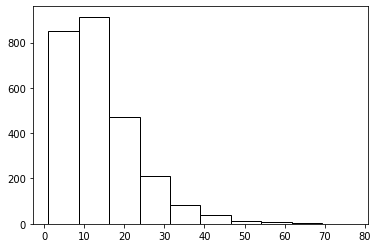

In [6]:
_, bins, _ = plt.hist(dataset, ec='black', color='white')
plt.show()

In [15]:
def tuple_to_string(pair):
    string = "Distribution = " + pair[0] + "\n"
    string += "p = " + str(pair[1]) + "\n"
    return string + "Parameters = " + str(pair[-1]) + "\n======="

def fit_dists(sample, possible_distributions):
    fitting = []
    for distribution in possible_distributions:
        dist = getattr(st, distribution)
        params = dist.fit(sample, floc=0)
        _, p_value = st.kstest(sample, distribution, args=params)
        fitting.append((distribution, p_value, params))

    fitting_str = list(map(lambda x: tuple_to_string(x), sorted(fitting, key=lambda y: y[1], reverse=True)))
    for fit in fitting_str:
        print(fit)
    return fitting

In [9]:
data.columns

Index(['ID', 'age', 'sex', 'city', 'province', 'country', 'latitude',
       'longitude', 'geo_resolution', 'date_onset_symptoms',
       'date_admission_hospital', 'date_confirmation', 'symptoms',
       'lives_in_Wuhan', 'travel_history_dates', 'travel_history_location',
       'reported_market_exposure', 'additional_information',
       'chronic_disease_binary', 'chronic_disease', 'source',
       'sequence_available', 'outcome', 'date_death_or_discharge',
       'notes_for_discussion', 'location', 'admin3', 'admin2', 'admin1',
       'country_new', 'admin_id', 'data_moderator_initials',
       'travel_history_binary'],
      dtype='object')

In [10]:
def reduce_sample(sample, perc_per_bin):
    # Creating first plot
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    _, bins, _ = ax1.hist(sample, ec='black', color='white')
    ax1.title.set_text('Original sample')

    # Separating bins
    data_bins = []
    for i in range(len(bins) - 1):
        data = []
        for j in range(sample.size):
            if bins[i] <= sample[j] <= bins[i + 1]:
                data.append(j)
        data_bins.append(data)
        
    # Remove data
    new_sample = []
    for data_bin in data_bins:
        for index in data_bin[int(perc_per_bin * len(data_bin)):]:
            new_sample.append(sample[index])
    
    new_sample = np.array(new_sample)
    # Creating new data plot
    _, bins, _ = ax2.hist(new_sample, ec='black', color='white')
    ax2.title.set_text('New sample')
    
    return new_sample

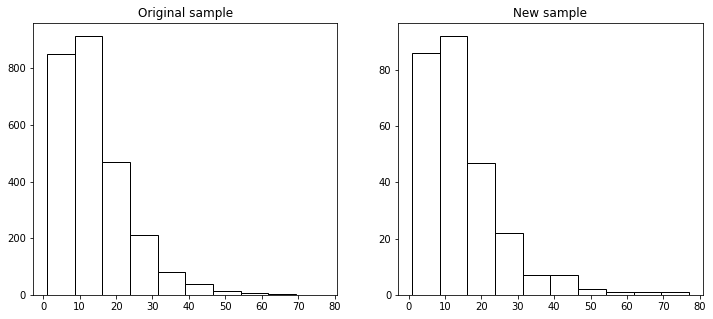

In [11]:
new_sample = reduce_sample(dataset, 0.9)

Distribution = beta
p = 0.00033659424023111957
Parameters = (1.8875069823269832, 22.98864037245216, 0, 182.79488908499076)
Distribution = gamma
p = 4.57717329986598e-05
Parameters = (2.030355526529144, 0, 6.828000066872237)
Distribution = lognorm
p = 1.3985334649516933e-20
Parameters = (0.8041395469908431, 0.0, 10.624998225825738)


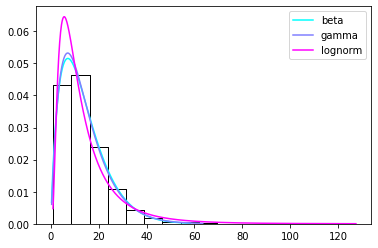

In [16]:
fitting = fit_dists(dataset, ["beta", "gamma", "lognorm"])

index = 0
color1 = plt.get_cmap('cool')
color_norm = colors.Normalize(vmin=0, vmax=len(fitting) - 1)
scalar_map = cm.ScalarMappable(norm=color_norm, cmap=color1)
for fit in fitting:
    dist1 = getattr(st, fit[0])
    params = fit[2]
    x1 = np.linspace(dist1.ppf(0.001, *params), dist1.ppf(0.999, *params), 1000)
    plt.plot(x1, dist1.pdf(x1, *params), color=scalar_map.to_rgba(index), label=fit[0])
    plt.hist(dataset, ec='black', color='white', density=True)
    index += 1

plt.legend()
plt.savefig("fitting-time.pdf", bbox_inches='tight')
plt.show()

Distribution = beta
p = 0.4880462516922025
Parameters = (1.9192624302225543, 4638239748541.4375, 0, 35328905183424.25)
Distribution = gamma
p = 0.4879028064766836
Parameters = (1.920230354061911, 0, 7.611868712763927)
Distribution = lognorm
p = 0.019476825384162323
Parameters = (0.8172313399085249, 0.0, 11.020066157827063)


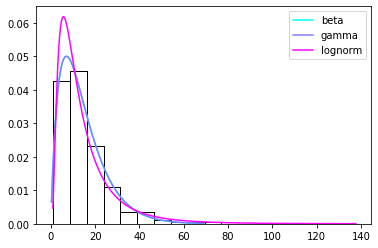

In [18]:
fitting = fit_dists(new_sample, ["beta", "gamma", "lognorm"])

index = 0
color1 = plt.get_cmap('cool')
color_norm = colors.Normalize(vmin=0, vmax=len(fitting) - 1)
scalar_map = cm.ScalarMappable(norm=color_norm, cmap=color1)
for fit in fitting:    
    dist1 = getattr(st, fit[0])
    params = fit[2]
    x1 = np.linspace(dist1.ppf(0.001, *params), dist1.ppf(0.999, *params), 1000)
    plt.plot(x1, dist1.pdf(x1, *params), color=scalar_map.to_rgba(index), label=fit[0])
    plt.hist(new_sample, ec='black', color='white', density=True)
    index += 1

plt.legend()
plt.savefig("fitting-time-reduced.pdf", bbox_inches='tight')
plt.show()

In [19]:
# Construct data set per age
age_sample = remove_nans('age', 'date_onset_symptoms', 'date_death_or_discharge')
age_dataset = list(filter(lambda x: x[1] > 0, map(lambda x: (x[0], date_to_days(x[1:])), age_sample)))
age_dataset = list(filter(lambda x: "-" not in x[0], age_dataset))

In [24]:
bins_ages = [(i, i + 9) for i in range(0, 80, 10)]
bins_ages.append((80, int(max(age_dataset, key=lambda x: float(x[0]))[0])))
data_per_age = {}
for data in age_dataset:
    for bin0 in bins_ages:
        if bin0[0] <= float(data[0]) <= bin0[1]:
            if bin0 in data_per_age:
                data_per_age[bin0].append(data[1])
            else:
                data_per_age[bin0] = [data[1]]
            break

print(list(sorted(map(lambda x: (x, len(data_per_age[x])), data_per_age), key=lambda x: x[0][0])))
data_per_age_1 = list(sorted(map(lambda x: (x, data_per_age[x]), data_per_age), key=lambda x: x[0][0]))

[((0, 9), 18), ((10, 19), 15), ((20, 29), 59), ((30, 39), 115), ((40, 49), 210), ((50, 59), 380), ((60, 69), 603), ((70, 79), 601), ((80, 105), 572)]


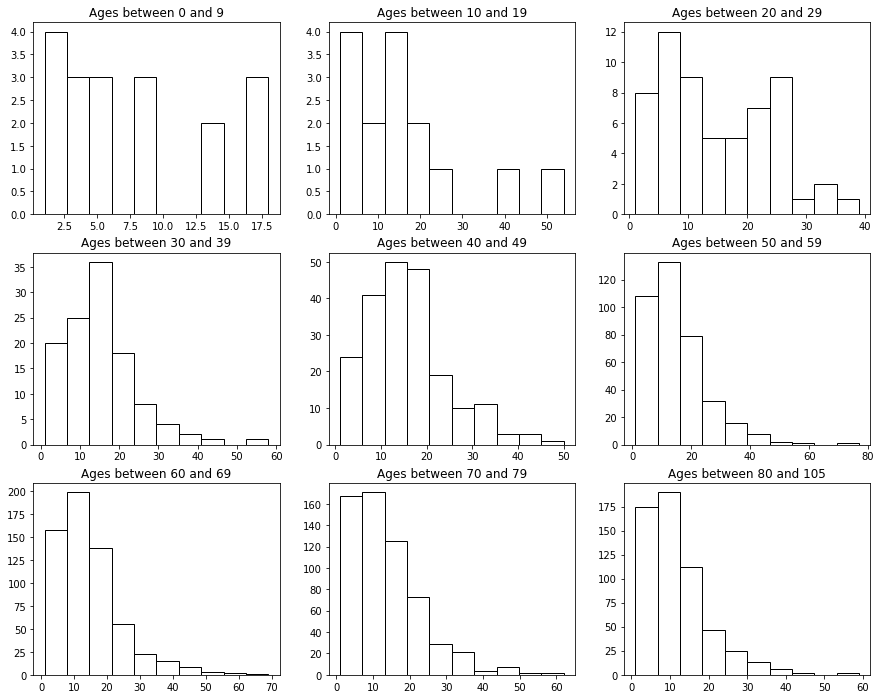

In [27]:
_, axs = plt.subplots(3, int(len(data_per_age) / 3), figsize=(15, 12))
index = [0, 0]
for elem in data_per_age_1:
    axs[index[0], index[1]].hist(elem[1], ec='black', color='white')
    axs[index[0], index[1]].title.set_text("Ages between " + str(elem[0][0]) + " and " + str(elem[0][1]))
    index[1] = (index[1] + 1) % 3
    if index[1] == 0:
        index[0] += 1
        index[1] = 0
plt.savefig("hists-per-age.pdf", bbox_inches='tight')
plt.show()

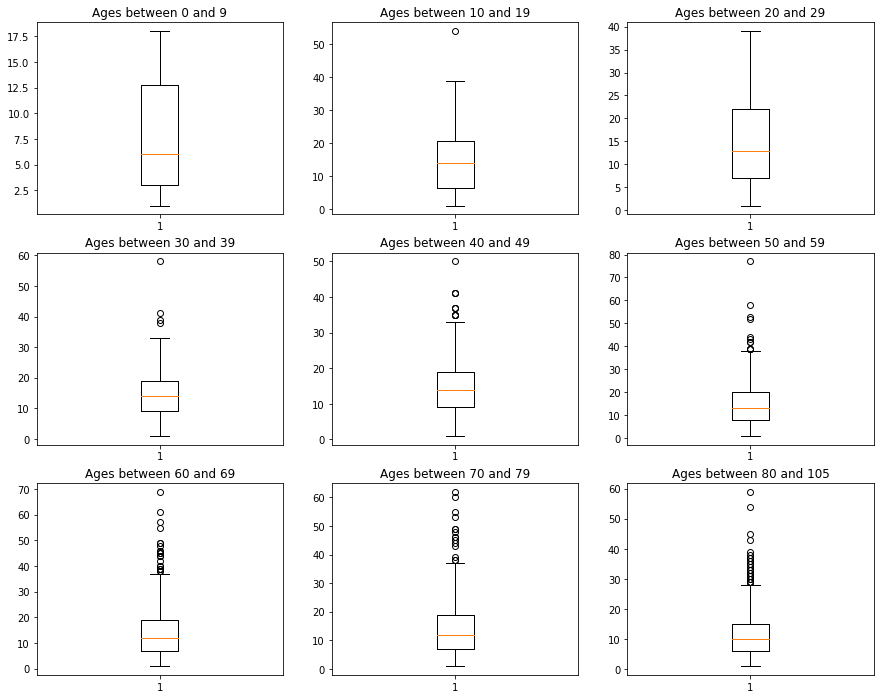

In [28]:
_, axs = plt.subplots(3, int(len(data_per_age) / 3), figsize=(15, 12))
index = [0, 0]
for elem in data_per_age_1:
    axs[index[0], index[1]].boxplot(elem[1])
    axs[index[0], index[1]].title.set_text("Ages between " + str(elem[0][0]) + " and " + str(elem[0][1]))
    index[1] = (index[1] + 1) % 3
    if index[1] == 0:
        index[0] += 1
        index[1] = 0
plt.savefig("boxplots-per-age.pdf", bbox_inches='tight')
plt.show()